# Imports

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import shutil
import wandb
import matplotlib.pyplot as plt

from wandb.keras import WandbMetricsLogger, WandbCallback

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from keras.layers.normalization.batch_normalization import BatchNormalization
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from keras.utils.vis_utils import plot_model

from keras import backend as K



# Loading all multimodel datasets

In [4]:
main_directory = '/media/workstation/BackupDrive/Dataset/'

# ava
ava_images = main_directory + 'data_512x/'
ava_multimodel_dataset = main_directory + 'multimodel_dataset/ava_multimodel_full_train_20_percent_val_test.csv'
ava_df = pd.read_csv(ava_multimodel_dataset)
# ava_df.drop(columns='Unnamed: 0', inplace=True)

# para
para_images = main_directory + 'PARA_512x_resized/'
para_multimodel_dataset = main_directory + 'multimodel_dataset/para_multimodel.csv'
para_df = pd.read_csv(para_multimodel_dataset)
para_df.drop(columns='Unnamed: 0', inplace=True)

# koniq 
koniq_images = main_directory + 'koniq10k_512x_image_in_csv/'
koniq_multimodel_dataset = main_directory + 'multimodel_dataset/koniq_multimodel.csv'
koniq_df = pd.read_csv(koniq_multimodel_dataset)
koniq_df.drop(columns='Unnamed: 0', inplace=True)

# spaq
spaq_images = main_directory + 'SPAQ_512x_resized/'
spaq_multimodel_dataset = main_directory + 'multimodel_dataset/spaq_multimodel.csv'
spaq_df = pd.read_csv(spaq_multimodel_dataset)
spaq_df.drop(columns='Unnamed: 0', inplace=True)

display(ava_df)
display(para_df)
display(koniq_df)
display(spaq_df)


,Index,dataset,ID,1,2,3,4,5,6,7,...,9,10,sem1,sem2,challegeID,sum_score,total_scorer,MOS,scaled_MOS_aesthetic,set
0,12,ava,953777.jpg,0,3,2,3,13,40,35,...,8,3,20,53,1396,844,128,6.593750,3.818291,training
1,21,ava,953550.jpg,0,0,1,3,13,45,36,...,5,7,14,0,1396,877,130,6.746154,3.908059,training
2,28,ava,954187.jpg,0,0,3,21,46,38,10,...,1,0,38,0,1396,654,122,5.360656,3.091981,training
3,83,ava,953933.jpg,0,0,9,19,63,25,9,...,1,1,15,19,1396,666,129,5.162791,2.975436,training
4,108,ava,953979.jpg,0,0,0,3,21,34,30,...,9,10,2,40,1396,872,127,6.866142,3.978733,training
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24426,123348,ava,263513.jpg,0,6,11,54,89,51,28,...,1,2,14,20,413,1333,254,5.248031,3.025644,test
24427,81633,ava,577031.jpg,0,0,2,11,56,48,19,...,3,1,14,21,721,828,145,5.710345,3.297953,test
24428,59759,ava,874523.jpg,3,15,22,37,61,46,23,...,9,2,18,41,1202,1154,226,5.106195,2.942100,test
24429,21933,ava,932076.jpg,4,4,10,42,57,42,17,...,3,1,1,2,1331,935,184,5.081522,2.927567,test


,dataset,sessionId,imageName,scaled_MOS_aesthetic,qualityScore,sessionId_imageName,set
0,para,session254,iaa_pub17770_.jpg,1.431034,1.413793,session254_iaa_pub17770_.jpg,test
1,para,session241,iaa_pub16811_.jpg,3.833333,3.995833,session241_iaa_pub16811_.jpg,test
2,para,session174,iaa_pub12164_.jpg,2.923077,3.046154,session174_iaa_pub12164_.jpg,training
3,para,session276,iaa_pub19290_.jpg,3.680000,3.752000,session276_iaa_pub19290_.jpg,training
4,para,session272,iaa_pub19007_.jpg,3.440000,3.556000,session272_iaa_pub19007_.jpg,training
...,...,...,...,...,...,...,...
11166,para,session403,iaa_pub28170_.jpg,3.060000,3.340000,session403_iaa_pub28170_.jpg,training
11167,para,session21,iaa_pub1456_.jpg,2.940000,3.232000,session21_iaa_pub1456_.jpg,training
11168,para,session425,iaa_pub29739_.jpg,2.820000,2.944000,session425_iaa_pub29739_.jpg,training
11169,para,session90,iaa_pub6243_.jpg,3.260000,3.408000,session90_iaa_pub6243_.jpg,training


,dataset,image_name,c1,c2,c3,c4,c5,c_total,scaled_MOS_quality,SD,MOS_zscore,set
0,koniq,10004473376.jpg,0,0,25,73,7,105,3.828571,0.527278,77.383621,training
1,koniq,10007357496.jpg,0,3,45,47,1,96,3.479167,0.580003,68.728571,test
2,koniq,10007903636.jpg,1,0,20,73,2,96,3.781250,0.527220,78.628571,training
3,koniq,10009096245.jpg,0,0,21,75,13,109,3.926606,0.556218,77.243750,training
4,koniq,100117038.jpg,0,1,21,72,6,100,3.830000,0.532860,75.112500,training
...,...,...,...,...,...,...,...,...,...,...,...,...
10068,koniq,9984535544.jpg,0,0,46,55,3,104,3.586538,0.550562,70.020089,test
10069,koniq,9991658304.jpg,0,1,12,85,6,104,3.923077,0.455651,79.337838,training
10070,koniq,9991999836.jpg,0,0,15,79,7,101,3.920792,0.462237,78.092437,test
10071,koniq,9995874256.jpg,0,3,53,51,1,108,3.462963,0.570717,68.095133,training


,dataset,Image name,MOS,Brightness,Colorfulness,Contrast,Noisiness,Sharpness,scaled_MOS_quality,set
0,spaq,07976.jpg,66.67,72.50,70.17,71.33,65.17,63.67,3.751915,validation
1,spaq,07515.jpg,28.00,50.75,47.25,43.88,50.63,25.88,2.106383,training
2,spaq,10664.jpg,31.00,51.71,38.14,44.14,33.86,13.17,2.234043,test
3,spaq,10558.jpg,73.17,69.33,76.50,71.33,67.00,75.67,4.028511,training
4,spaq,01972.jpg,63.40,55.70,69.50,67.80,57.09,69.40,3.612766,training
...,...,...,...,...,...,...,...,...,...,...
11120,spaq,09138.jpg,53.40,66.60,63.60,58.20,31.20,46.60,3.187234,training
11121,spaq,02544.jpg,16.09,28.36,30.45,32.09,41.30,4.90,1.599574,training
11122,spaq,06378.jpg,22.50,52.38,56.63,51.00,22.63,9.88,1.872340,training
11123,spaq,09206.jpg,56.33,46.56,57.56,55.00,59.44,63.11,3.311915,training


In [12]:
ava_train_df = ava_df[ava_df['set']=='training']
ava_val_df = ava_df[ava_df['set']=='validation']
ava_test_df = ava_df[ava_df['set']=='test']

para_train_df = para_df[para_df['set']=='training']
para_val_df = para_df[para_df['set']=='validation']
para_test_df = para_df[para_df['set']=='test']

koniq_train_df = koniq_df[koniq_df['set']=='training']
koniq_val_df = koniq_df[koniq_df['set']=='validation']
koniq_test_df = koniq_df[koniq_df['set']=='test']

spaq_train_df = spaq_df[spaq_df['set']=='training']
spaq_val_df = spaq_df[spaq_df['set']=='validation']
spaq_test_df = spaq_df[spaq_df['set']=='test']

,dataset,Image name,MOS,Brightness,Colorfulness,Contrast,Noisiness,Sharpness,scaled_MOS_quality,set
1,spaq,07515.jpg,28.00,50.75,47.25,43.88,50.63,25.88,2.106383,training
3,spaq,10558.jpg,73.17,69.33,76.50,71.33,67.00,75.67,4.028511,training
4,spaq,01972.jpg,63.40,55.70,69.50,67.80,57.09,69.40,3.612766,training
6,spaq,08532.jpg,80.20,79.20,82.90,78.30,81.80,79.50,4.327660,training
7,spaq,09365.jpg,25.00,43.78,26.22,16.44,32.44,13.44,1.978723,training
...,...,...,...,...,...,...,...,...,...,...
11120,spaq,09138.jpg,53.40,66.60,63.60,58.20,31.20,46.60,3.187234,training
11121,spaq,02544.jpg,16.09,28.36,30.45,32.09,41.30,4.90,1.599574,training
11122,spaq,06378.jpg,22.50,52.38,56.63,51.00,22.63,9.88,1.872340,training
11123,spaq,09206.jpg,56.33,46.56,57.56,55.00,59.44,63.11,3.311915,training


,dataset,Image name,MOS,Brightness,Colorfulness,Contrast,Noisiness,Sharpness,scaled_MOS_quality,set
0,spaq,07976.jpg,66.67,72.50,70.17,71.33,65.17,63.67,3.751915,validation
11,spaq,02522.jpg,56.00,56.18,57.45,60.45,57.30,52.09,3.297872,validation
21,spaq,08558.jpg,69.50,65.00,70.50,64.75,74.75,65.25,3.872340,validation
26,spaq,05088.jpg,31.83,42.30,55.91,51.91,40.75,14.64,2.269362,validation
27,spaq,02628.jpg,48.70,45.50,56.50,44.67,46.30,40.90,2.987234,validation
...,...,...,...,...,...,...,...,...,...,...
11079,spaq,03607.jpg,69.91,70.64,73.45,71.10,66.64,70.91,3.889787,validation
11080,spaq,05174.jpg,10.40,5.89,37.50,23.56,33.00,3.80,1.357447,validation
11081,spaq,02446.jpg,51.70,57.44,47.00,54.33,48.10,52.30,3.114894,validation
11089,spaq,03969.jpg,47.25,41.25,51.83,51.42,54.08,52.83,2.925532,validation


,dataset,Image name,MOS,Brightness,Colorfulness,Contrast,Noisiness,Sharpness,scaled_MOS_quality,set
2,spaq,10664.jpg,31.00,51.71,38.14,44.14,33.86,13.17,2.234043,test
5,spaq,02979.jpg,30.89,38.10,57.22,50.11,49.10,16.60,2.229362,test
9,spaq,06700.jpg,53.17,55.00,47.67,50.67,57.33,52.83,3.177447,test
14,spaq,08568.jpg,65.50,61.25,65.00,68.25,69.00,67.25,3.702128,test
20,spaq,09323.jpg,69.13,70.75,75.38,65.13,59.13,66.25,3.856596,test
...,...,...,...,...,...,...,...,...,...,...
11086,spaq,06062.jpg,33.89,57.00,53.67,57.89,47.22,20.78,2.357021,test
11092,spaq,10571.jpg,28.29,52.57,54.57,48.86,27.14,8.20,2.118723,test
11093,spaq,05861.jpg,59.80,52.00,65.00,55.00,56.60,56.80,3.459574,test
11117,spaq,05853.jpg,58.67,65.50,64.17,56.50,53.00,61.17,3.411489,test


### Split images into train-validation-test ImageDataGenerator, for all datasets

In [14]:
# Set the path to the directory where you want to save the split datasets
ava_images = main_directory + 'AVA/data_512x/'
para_images = main_directory + 'PARA/PARA_512x_resized/'
koniq_images = main_directory + 'koniq10k/koniq10k_512x_image_in_csv/'
spaq_images = main_directory + 'SPAQ dataset-20230407T121509Z-008/SPAQ_512x_resized/'

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# ava
ava_train_generator = train_datagen.flow_from_dataframe(
    dataframe=ava_train_df,
    directory=ava_images, 
    x_col="ID", 
    y_col="scaled_MOS_aesthetic", 
    class_mode="raw", 
    target_size=(224, 224), 
    batch_size=16
)

ava_val_generator = val_datagen.flow_from_dataframe(
    dataframe=ava_val_df, 
    directory=ava_images, 
    x_col="ID", 
    y_col="scaled_MOS_aesthetic", 
    class_mode="raw", 
    target_size=(224, 224), 
    batch_size=16
)

ava_test_generator = test_datagen.flow_from_dataframe(
    dataframe=ava_test_df, 
    directory=ava_images, 
    x_col="ID", 
    y_col="scaled_MOS_aesthetic", 
    class_mode="raw", 
    target_size=(224, 224), 
    batch_size=16
)
print('AVA generators complete\n')

# para
para_train_generator = train_datagen.flow_from_dataframe(
    dataframe=para_train_df,
    directory=para_images, 
    x_col="sessionId_imageName", 
    y_col="scaled_MOS_aesthetic", 
    class_mode="raw", 
    target_size=(224, 224), 
    batch_size=16
)

para_val_generator = val_datagen.flow_from_dataframe(
    dataframe=para_val_df, 
    directory=para_images, 
    x_col="sessionId_imageName", 
    y_col="scaled_MOS_aesthetic", 
    class_mode="raw", 
    target_size=(224, 224), 
    batch_size=16
)

para_test_generator = test_datagen.flow_from_dataframe(
    dataframe=para_test_df, 
    directory=para_images, 
    x_col="sessionId_imageName", 
    y_col="scaled_MOS_aesthetic", 
    class_mode="raw", 
    target_size=(224, 224), 
    batch_size=16
)
print('PARA generators complete\n')

# koniq
koniq_train_generator = train_datagen.flow_from_dataframe(
    dataframe=koniq_train_df,
    directory=koniq_images, 
    x_col="image_name", 
    y_col="scaled_MOS_quality", 
    class_mode="raw", 
    target_size=(224, 224), 
    batch_size=16
)

koniq_val_generator = val_datagen.flow_from_dataframe(
    dataframe=koniq_val_df, 
    directory=koniq_images, 
    x_col="image_name", 
    y_col="scaled_MOS_quality", 
    class_mode="raw", 
    target_size=(224, 224), 
    batch_size=16
)

koniq_test_generator = test_datagen.flow_from_dataframe(
    dataframe=koniq_test_df, 
    directory=koniq_images, 
    x_col="image_name", 
    y_col="scaled_MOS_quality", 
    class_mode="raw", 
    target_size=(224, 224), 
    batch_size=16
)
print('KoNIQ generators complete\n')

# spaq
spaq_train_generator = train_datagen.flow_from_dataframe(
    dataframe=spaq_train_df,
    directory=spaq_images, 
    x_col="Image name", 
    y_col="scaled_MOS_quality", 
    class_mode="raw", 
    target_size=(224, 224), 
    batch_size=16
)

spaq_val_generator = val_datagen.flow_from_dataframe(
    dataframe=spaq_val_df, 
    directory=spaq_images, 
    x_col="Image name", 
    y_col="scaled_MOS_quality", 
    class_mode="raw", 
    target_size=(224, 224), 
    batch_size=16
)

spaq_test_generator = test_datagen.flow_from_dataframe(
    dataframe=spaq_test_df, 
    directory=spaq_images, 
    x_col="Image name", 
    y_col="scaled_MOS_quality", 
    class_mode="raw", 
    target_size=(224, 224), 
    batch_size=16
)
print('SPAQ generators complete\n')

Found 19924 validated image filenames.
Found 2492 validated image filenames.
Found 2015 validated image filenames.
AVA generators complete

Found 8156 validated image filenames.
Found 1000 validated image filenames.
Found 2015 validated image filenames.
PARA generators complete

Found 7058 validated image filenames.
Found 1000 validated image filenames.
Found 2015 validated image filenames.
KoNIQ generators complete

Found 8110 validated image filenames.
Found 1000 validated image filenames.
Found 2015 validated image filenames.
SPAQ generators complete



# Model Training (InceptionResNetV2)

## wandb configs

### Create the PLCC custom metric first

In [15]:
def plcc_tf(x, y):
    """PLCC metric"""
    xc = x - K.mean(x)
    yc = y - K.mean(y)
    return K.mean(xc*yc)/(K.std(x)*K.std(y) + K.epsilon())

def pearson_correlation(y_true, y_pred):
    # Subtract the mean from true and predicted values
    y_true_mean = K.mean(y_true)
    y_pred_mean = K.mean(y_pred)
    y_true_centered = y_true - y_true_mean
    y_pred_centered = y_pred - y_pred_mean

    # Calculate covariance and standard deviation
    covariance = K.mean(y_true_centered * y_pred_centered)
    y_true_std = K.std(y_true)
    y_pred_std = K.std(y_pred)

    # Calculate Pearson correlation coefficient
    pearson_coefficient = covariance / (y_true_std * y_pred_std + K.epsilon())

    return pearson_coefficient

In [16]:
class CustomMetricCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Calculate the custom metric
        y_true = self.validation_data[1]
        y_pred = self.model.predict(self.validation_data[0])
        pearson_coefficient = pearson_correlation(y_true, y_pred)

        # Log the custom metric using wandb
        wandb.log({"val_pearson_coefficient": pearson_coefficient})

In [21]:
wandb.init(
    # set the wandb project where this run will be logged
    project="multimodel_irnv2",
    dir = "/media/workstation/BackupDrive/wandb_files/logs",

    # track hyperparameters and run metadata with wandb.config
    config={
        "fc1" : 2048,
        "activation1" : 'relu',
        "dropout1": 0.25,
        "fc2" : 1024,
        "activation2" : 'relu',
        "dropout2": 0.25,
        "fc3" : 256,
        "activation3" : 'relu',
        "dropout3": 0.5,
        "fc4" : 1,
        "activation4" : 'linear',
        "dropout4": 0,
        "learning_rate" : 0.0005,
        "optimizer": "adam",
        "loss": "mean_squared_error",
        "metric": "root_mean_squared_error",
        "epoch": 100,
        "batch_size": 16,
        "metric2" : "val_Output_KonIQ_quality_pearson_correlation",
        "early_patience" : 10,
        "early_mode" : 'max',
        "early_min_delta" : 0.001,
        "plateau_patience" : 5,
        "plateau_mode" : "max",
        "plateau_factor" : 0.2,
        "plateau_min_lr" : 0.000004,
        "plateau_min_delta" : 0.01
    }
)

config = wandb.config

Output_AVA_aesthetic_loss,█▂▂▁▁▁▁
Output_AVA_aesthetic_pearson_correlation,▁▁▆█▇█▃
Output_AVA_aesthetic_root_mean_squared_error,█▃▂▂▁▁▁
Output_KonIQ_quality_loss,█▂▂▁▁▁▁
Output_KonIQ_quality_pearson_correlation,▁▃▄▅▇██
Output_KonIQ_quality_root_mean_squared_error,█▃▂▁▁▁▁
Output_PARA_aesthetic_loss,█▂▂▁▁▁▁
Output_PARA_aesthetic_pearson_correlation,▁▃▅▅▆██
Output_PARA_aesthetic_root_mean_squared_error,█▃▂▂▁▁▁
Output_SPAQ_quality_loss,█▂▂▁▁▁▁
Output_SPAQ_quality_pearson_correlation,▁▃▅▆▇██


In [22]:
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# function to create outputs
def configure_layers(input, name='Output normal'):
    x = GlobalAveragePooling2D()(input)
    x = Dense(config.fc1, activation=config.activation1)(x)
    x = BatchNormalization()(x)
    x = Dropout(config.dropout1)(x)

    x = Dense(config.fc2, activation=config.activation2)(x)
    x = BatchNormalization()(x)
    x = Dropout(config.dropout2)(x)

    x = Dense(config.fc3, activation=config.activation3)(x)
    x = BatchNormalization()(x)
    x = Dropout(config.dropout3)(x)

    predictions = Dense(config.fc4, activation=config.activation4, name=name)(x)
    return predictions

# Create the input layers
input_ava = Input(shape=(224, 224, 3), name='Input_AVA')
input_para = Input(shape=(224, 224, 3), name='Input_PARA')
input_koniq = Input(shape=(224, 224, 3), name='Input_KonIQ')
input_spaq = Input(shape=(224, 224, 3), name='Input_SPAQ')

# Create the output layers, include the input layers 
output_ava = configure_layers(base_model(input_ava), name='Output_AVA_aesthetic')
output_para = configure_layers(base_model(input_para), name='Output_PARA_aesthetic')
output_koniq = configure_layers(base_model(input_koniq), name='Output_KonIQ_quality')
output_spaq = configure_layers(base_model(input_spaq), name='Output_SPAQ_quality')

# Create the final model, include the multi-output
model = Model(inputs=[input_ava, input_para, input_koniq, input_spaq], 
              outputs=[output_ava, output_para, output_koniq, output_spaq])

optimizer = keras.optimizers.Adam(learning_rate=config.learning_rate)

# Compile the model
model.compile(optimizer=optimizer,
              loss=config.loss,
              metrics=[tf.keras.metrics.RootMeanSquaredError(), pearson_correlation]
              )

checkpoint_filepath = main_directory + 'multimodel_dataset/multimodel_checkpoint/'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_best_only=True,
    monitor='val_Output_KonIQ_quality_pearson_correlation',
    mode='min'
    )

early_stopping_callback = EarlyStopping(
    monitor= config.metric2, 
    patience=config.early_patience,
    mode=config.early_mode,
    min_delta = config.early_min_delta
    )

reduce_lr_callback = ReduceLROnPlateau(
    monitor = config.metric2,
    factor = config.plateau_factor,
    patience = config.plateau_patience,
    mode = config.plateau_mode,
    min_lr = config.plateau_min_lr
)


In [23]:
# Define the number of steps per epoch for each generator
steps_per_epoch1 = len(ava_train_generator)
steps_per_epoch2 = len(para_train_generator)
steps_per_epoch3 = len(koniq_train_generator)
steps_per_epoch4 = len(spaq_train_generator)

# Define the number of validation steps for each generator
val_steps1 = len(ava_val_generator)
val_steps2 = len(para_val_generator)
val_steps3 = len(koniq_val_generator)
val_steps4 = len(spaq_val_generator)

def combined_generator(gen1, gen2, gen3, gen4):
    while True:
        batch1 = next(gen1)
        batch2 = next(gen2)
        batch3 = next(gen3)
        batch4 = next(gen4)
        inputs = [batch1[0], batch2[0], batch3[0], batch4[0]]
        targets = [batch1[1], batch2[1], batch3[1], batch4[1]]
        yield inputs, targets

combined_train_gen = combined_generator(ava_train_generator, para_train_generator, koniq_train_generator, spaq_train_generator)

combined_val_gen = combined_generator(ava_val_generator, para_val_generator, koniq_val_generator, spaq_val_generator)

history = model.fit(x=combined_train_gen,
                    steps_per_epoch = max(steps_per_epoch1, steps_per_epoch2, steps_per_epoch3, steps_per_epoch4),
                    epochs = config.epoch,
                    validation_data = combined_val_gen,
                    validation_steps = max(val_steps1, val_steps2, val_steps3, val_steps4),
                    callbacks = [
                      WandbMetricsLogger(log_freq=5),
                      WandbCallback(monitor='val_Output_KonIQ_quality_pearson_correlation', mode='max', save_model=False, save_weights_only=False),
                      model_checkpoint_callback,
                      early_stopping_callback,
                      reduce_lr_callback
                    ])

wandb.finish()

Epoch 1/100


2023-07-09 04:06:44.860312: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2023-07-09 04:06:46.209174: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.09GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-07-09 04:06:46.226598: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.09GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-07-09 04:06:46.230055: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory

1246/1246 [==============================] - 1082s 827ms/step - loss: 11.8184 - Output_AVA_aesthetic_loss: 2.9066 - Output_PARA_aesthetic_loss: 2.9776 - Output_KonIQ_quality_loss: 2.9212 - Output_SPAQ_quality_loss: 3.0129 - Output_AVA_aesthetic_root_mean_squared_error: 1.7049 - Output_AVA_aesthetic_pearson_correlation: 0.0049 - Output_PARA_aesthetic_root_mean_squared_error: 1.7253 - Output_PARA_aesthetic_pearson_correlation: 0.0928 - Output_KonIQ_quality_root_mean_squared_error: 1.7100 - Output_KonIQ_quality_pearson_correlation: 0.1778 - Output_SPAQ_quality_root_mean_squared_error: 1.7354 - Output_SPAQ_quality_pearson_correlation: 0.3881 - val_loss: 1.2698 - val_Output_AVA_aesthetic_loss: 0.2507 - val_Output_PARA_aesthetic_loss: 0.2941 - val_Output_KonIQ_quality_loss: 0.2680 - val_Output_SPAQ_quality_loss: 0.4570 - val_Output_AVA_aesthetic_root_mean_squared_error: 0.5007 - val_Output_AVA_aesthetic_pearson_correlation: 0.1054 - val_Output_PARA_aesthetic_root_mean_squared_error: 0.5438 -

KeyboardInterrupt: 

In [24]:
wandb.finish()

Output_AVA_aesthetic_loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Output_AVA_aesthetic_pearson_correlation,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▆▇▇▇▇██████████████████
Output_AVA_aesthetic_root_mean_squared_error,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Output_KonIQ_quality_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Output_KonIQ_quality_pearson_correlation,▁▂▄▄▄▅▅▆▆▆▆▇▇▇▇▇███████████████████████
Output_KonIQ_quality_root_mean_squared_error,█▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Output_PARA_aesthetic_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Output_PARA_aesthetic_pearson_correlation,▁▂▃▄▄▄▅▆▆▆▆▇▇▇▇▇███████████████████████
Output_PARA_aesthetic_root_mean_squared_error,█▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Output_SPAQ_quality_loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Output_SPAQ_quality_pearson_correlation,▁▄▅▆▆▆▆▇▇▇▇▇▇▇█████████████████████████


In [25]:
combined_test_gen = combined_generator(ava_test_generator, para_test_generator, koniq_test_generator, spaq_test_generator)

# Define the number of validation steps for each generator
test_steps1 = len(ava_test_generator)
test_steps2 = len(para_test_generator)
test_steps3 = len(koniq_test_generator)
test_steps4 = len(spaq_test_generator)

# Evaluate the model on the preprocessed test data
evaluation = model.evaluate(
    combined_test_gen,
    steps=max(test_steps1, test_steps2, test_steps3, test_steps4)
)

126/126 [==============================] - 128s 1s/step - loss: 0.5662 - Output_AVA_aesthetic_loss: 0.2141 - Output_PARA_aesthetic_loss: 0.0822 - Output_KonIQ_quality_loss: 0.0808 - Output_SPAQ_quality_loss: 0.1891 - Output_AVA_aesthetic_root_mean_squared_error: 0.4627 - Output_AVA_aesthetic_pearson_correlation: 0.4838 - Output_PARA_aesthetic_root_mean_squared_error: 0.2867 - Output_PARA_aesthetic_pearson_correlation: 0.8101 - Output_KonIQ_quality_root_mean_squared_error: 0.2843 - Output_KonIQ_quality_pearson_correlation: 0.8553 - Output_SPAQ_quality_root_mean_squared_error: 0.4349 - Output_SPAQ_quality_pearson_correlation: 0.7916


2023-07-09 15:18:10.072124: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.03GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


In [25]:
saved_model_path = '/media/workstation/BackupDrive/model/multimodel_irnv2/'

model.save(saved_model_path + 'multimodel_irnv2_easy_flower_9.h5')
model.save_weights(saved_model_path + 'multimodel_irnv2_weights_easy_flower_9.h5')

# Prediction

In [48]:
ava_test_generator = test_datagen.flow_from_dataframe(
    dataframe=ava_test_df, 
    directory=ava_images, 
    x_col="ID", 
    y_col="scaled_MOS_aesthetic", 
    shuffle=False,
    class_mode="raw", 
    target_size=(224, 224), 
    batch_size=1
)

para_test_generator = test_datagen.flow_from_dataframe(
    dataframe=para_test_df, 
    directory=para_images, 
    x_col="sessionId_imageName", 
    y_col="scaled_MOS_aesthetic", 
    shuffle=False,
    class_mode="raw", 
    target_size=(224, 224), 
    batch_size=1
)

koniq_test_generator = test_datagen.flow_from_dataframe(
    dataframe=koniq_test_df, 
    directory=koniq_images, 
    x_col="image_name", 
    y_col="scaled_MOS_quality", 
    shuffle=False,
    class_mode="raw", 
    target_size=(224, 224), 
    batch_size=1
)

spaq_test_generator = test_datagen.flow_from_dataframe(
    dataframe=spaq_test_df, 
    directory=spaq_images, 
    x_col="Image name", 
    y_col="scaled_MOS_quality", 
    shuffle=False,
    class_mode="raw", 
    target_size=(224, 224), 
    batch_size=1
)

Found 2015 validated image filenames.
Found 2015 validated image filenames.
Found 2015 validated image filenames.
Found 2015 validated image filenames.


In [49]:
import scipy 

def plcc(x, y):
    '''Pearson Linear Correlation Coefficient'''
    x, y = np.float32(x), np.float32(y)
    return scipy.stats.pearsonr(x,y)[0]

def srocc(xs, ys):
    '''Spearman Rank Order Correlation Coefficient'''
    correlation, p_value = scipy.stats.spearmanr(xs, ys)
    return correlation

def rmse(y_test, y_pred):
    mse = np.mean((y_test - y_pred) ** 2)
    return np.sqrt(mse)
    

In [50]:
combined_test_gen = combined_generator(ava_test_generator, para_test_generator, koniq_test_generator, spaq_test_generator)

# Define the number of validation steps for each generator
test_steps1 = len(ava_test_generator)
test_steps2 = len(para_test_generator)
test_steps3 = len(koniq_test_generator)
test_steps4 = len(spaq_test_generator)

prediction = model.predict(
    combined_test_gen,
    steps=max(test_steps1, test_steps2, test_steps3, test_steps4)
)

In [51]:
df_num = 0
for prediction_list in prediction:
    test_list = []
    test_list = prediction_list.tolist()
    test_list = [val[0] for val in test_list]
    if df_num == 0:
        ava_pred_df = ava_test_df.copy()
        ava_pred_df['pred_mos_aesthetic'] = test_list
        df_num += 1
    elif df_num == 1:
        para_pred_df = para_test_df.copy()
        para_pred_df['pred_mos_aesthetic'] = test_list
        df_num += 1
    elif df_num == 2:
        koniq_pred_df = koniq_test_df.copy()
        koniq_pred_df['pred_mos_quality'] = test_list
        df_num += 1
    elif df_num == 3:
        spaq_pred_df = spaq_test_df.copy()
        spaq_pred_df['pred_mos_quality'] = test_list
        df_num += 1
    

,Index,dataset,ID,1,2,3,4,5,6,7,...,10,sem1,sem2,challegeID,sum_score,total_scorer,MOS,scaled_MOS_aesthetic,set,pred_mos_aesthetic
22416,34515,ava,914050.jpg,0,1,5,2,15,40,48,...,10,2,20,1281,1371,193,7.103627,4.118615,test,3.673047
22417,66231,ava,41959.jpg,1,0,4,14,26,52,24,...,4,18,22,146,844,140,6.028571,3.485393,test,3.573775
22418,173481,ava,650443.jpg,0,0,1,17,72,65,31,...,0,19,21,821,1169,202,5.787129,3.343180,test,3.686857
22419,158162,ava,220734.jpg,0,8,29,100,165,112,46,...,3,17,26,370,2550,487,5.236140,3.018639,test,2.880749
22420,104085,ava,444720.jpg,0,0,4,9,42,61,37,...,3,2,20,596,1020,169,6.035503,3.489476,test,3.331942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24426,123348,ava,263513.jpg,0,6,11,54,89,51,28,...,2,14,20,413,1333,254,5.248031,3.025644,test,3.543407
24427,81633,ava,577031.jpg,0,0,2,11,56,48,19,...,1,14,21,721,828,145,5.710345,3.297953,test,3.540812
24428,59759,ava,874523.jpg,3,15,22,37,61,46,23,...,2,18,41,1202,1154,226,5.106195,2.942100,test,3.342979
24429,21933,ava,932076.jpg,4,4,10,42,57,42,17,...,1,1,2,1331,935,184,5.081522,2.927567,test,2.909036


,dataset,sessionId,imageName,scaled_MOS_aesthetic,qualityScore,sessionId_imageName,set,pred_mos_aesthetic
0,para,session254,iaa_pub17770_.jpg,1.431034,1.413793,session254_iaa_pub17770_.jpg,test,2.507247
1,para,session241,iaa_pub16811_.jpg,3.833333,3.995833,session241_iaa_pub16811_.jpg,test,3.869065
12,para,session431,iaa_pub30170_.jpg,3.280000,3.356000,session431_iaa_pub30170_.jpg,test,3.317594
27,para,session70,iaa_pub4849_.jpg,3.800000,3.856000,session70_iaa_pub4849_.jpg,test,3.592565
33,para,session161,iaa_pub11239_.jpg,3.879310,4.034483,session161_iaa_pub11239_.jpg,test,3.635009
...,...,...,...,...,...,...,...,...
11132,para,session200,iaa_pub13994_.jpg,2.760000,2.968000,session200_iaa_pub13994_.jpg,test,2.334258
11138,para,session262,iaa_pub18288_.jpg,2.400000,2.488000,session262_iaa_pub18288_.jpg,test,2.809561
11139,para,session336,iaa_pub23502_.jpg,3.540000,3.776000,session336_iaa_pub23502_.jpg,test,3.522117
11163,para,session421,iaa_pub29421_.jpg,3.288462,3.546154,session421_iaa_pub29421_.jpg,test,3.479589


,dataset,image_name,c1,c2,c3,c4,c5,c_total,scaled_MOS_quality,SD,MOS_zscore,set,pred_mos_quality
1,koniq,10007357496.jpg,0,3,45,47,1,96,3.479167,0.580003,68.728571,test,3.431759
9,koniq,10020766793.jpg,0,0,11,78,20,109,4.082569,0.529298,81.506250,test,3.393662
10,koniq,10020891105.jpg,0,4,80,18,0,102,3.137255,0.445866,56.829741,test,3.135292
11,koniq,10022757465.jpg,0,3,32,66,4,105,3.676190,0.596387,71.015487,test,3.271204
18,koniq,10039534103.jpg,0,0,34,72,1,107,3.691589,0.483915,76.075000,test,3.180727
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10050,koniq,9936084895.jpg,0,5,63,30,0,98,3.255102,0.543210,61.648649,test,3.380039
10065,koniq,9977056676.jpg,0,34,64,5,0,103,2.718447,0.549821,46.301339,test,2.960097
10066,koniq,9977191265.jpg,0,1,44,58,5,108,3.620370,0.591491,74.471698,test,3.499641
10068,koniq,9984535544.jpg,0,0,46,55,3,104,3.586538,0.550562,70.020089,test,3.464988


,dataset,Image name,MOS,Brightness,Colorfulness,Contrast,Noisiness,Sharpness,scaled_MOS_quality,set,pred_mos_quality
2,spaq,10664.jpg,31.00,51.71,38.14,44.14,33.86,13.17,2.234043,test,2.588847
5,spaq,02979.jpg,30.89,38.10,57.22,50.11,49.10,16.60,2.229362,test,2.723767
9,spaq,06700.jpg,53.17,55.00,47.67,50.67,57.33,52.83,3.177447,test,3.100795
14,spaq,08568.jpg,65.50,61.25,65.00,68.25,69.00,67.25,3.702128,test,3.285597
20,spaq,09323.jpg,69.13,70.75,75.38,65.13,59.13,66.25,3.856596,test,3.356549
...,...,...,...,...,...,...,...,...,...,...,...
11086,spaq,06062.jpg,33.89,57.00,53.67,57.89,47.22,20.78,2.357021,test,2.392219
11092,spaq,10571.jpg,28.29,52.57,54.57,48.86,27.14,8.20,2.118723,test,2.448367
11093,spaq,05861.jpg,59.80,52.00,65.00,55.00,56.60,56.80,3.459574,test,3.280375
11117,spaq,05853.jpg,58.67,65.50,64.17,56.50,53.00,61.17,3.411489,test,3.186589


SRCC/PLCC/RMSE 0.777/0.804/0.435


Text(0.5, 0.98, 'Quality Score Ground truth - Prediction')

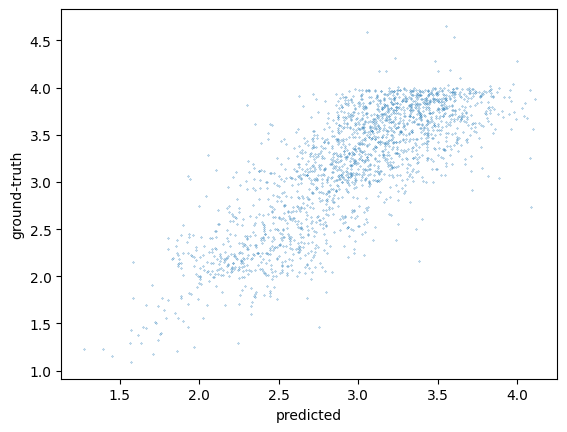

<Figure size 640x480 with 0 Axes>

In [55]:
y_test = np.array(spaq_pred_df.loc[:, 'scaled_MOS_quality'])
y_pred = np.array(spaq_pred_df.loc[:, 'pred_mos_quality'])

SRCC_test = round(srocc(y_pred, y_test), 3)
PLCC_test = round(plcc(y_pred, y_test), 3)
rmse_test = round(rmse(y_test, y_pred), 3)
print('SRCC/PLCC/RMSE {}/{}/{}'.format(SRCC_test, PLCC_test, rmse_test))

plt.plot(y_pred, y_test, '.', markersize=0.5)
plt.xlabel('predicted'); plt.ylabel('ground-truth'); plt.show
fig = plt.figure()
fig.suptitle('Quality Score Ground truth - Prediction')

In [56]:
# save the test_df for prediction later on
ava_test_df.to_csv(main_directory + 'multimodel_dataset/prediction/predict_baseline_multimodel_ava.csv')
para_test_df.to_csv(main_directory + 'multimodel_dataset/prediction/predict_baseline_multimodel_para.csv')
koniq_test_df.to_csv(main_directory + 'multimodel_dataset/prediction/predict_baseline_multimodel_koniq.csv')
spaq_test_df.to_csv(main_directory + 'multimodel_dataset/prediction/predict_baseline_multimodel_spaq.csv')